In [1]:
import sqlite3
import logging
import pandas as pd
from urllib.parse import urlparse
from tld import get_tld, get_fld
from matplotlib import pyplot as plt
from http.cookies import SimpleCookie

plt.rcParams['figure.figsize'] = [20, 10]


In [2]:
# Specify your local path to the sqlite db containing crawl data
SQLITE_LOCAL_PATH = '/Users/liam/dev/OpenWPM/data/gemeente_social_complete.sqlite'
SM_FLDS = ['facebook', 'instagram', 'linkedin', 'google', 'youtube', 'twitter']

In [3]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect(SQLITE_LOCAL_PATH)

cursor = con.cursor()

# Parse javascript table from SQLite
javascript = pd.read_sql_query("SELECT * from javascript", con)
# Parse SITE_VISITS table from SQLite
site_visits = pd.read_sql_query("SELECT * from site_visits", con)

#Drop what we don't need
javascript = javascript.drop(["script_loc_eval", "page_scoped_event_ordinal", "event_ordinal", "id", "incognito", "frame_id", "script_line", "script_col", "crawl_id", "extension_session_uuid", "tab_id", "window_id"], axis=1)

print(javascript.columns)
print(site_visits.columns)

Index(['visit_id', 'script_url', 'func_name', 'document_url', 'top_level_url',
       'call_stack', 'symbol', 'operation', 'value', 'arguments',
       'time_stamp'],
      dtype='object')
Index(['visit_id', 'crawl_id', 'site_url', 'parent_url'], dtype='object')


In [4]:
# Join the site_visits information into the javascript for a complete dataset and we can select columns next
all_columns = javascript.set_index('visit_id').join(site_visits.set_index('visit_id'), lsuffix='_javascript', rsuffix='_site_visits')

# More filtering of columns
javascript_analysis_set = all_columns[["script_url", "top_level_url", "symbol", "operation", "value", "arguments", "time_stamp", "site_url", "parent_url"]]



In [5]:
# Helper function to get TLD+1 level of crawled link.
def parse_tld_url(url):
    return get_fld(url, fail_silently=True)

js_analysis = javascript_analysis_set.copy()

#Get the script_url's top level domain into script_url_tld
js_analysis['script_url_tld'] = js_analysis.copy()['script_url'].apply(parse_tld_url)

# parent_url (the top level gemeente site) -> site_url (gemeente site or one link off gemeente) -> script_url (js event hosted by)
js_analysis


,script_url,top_level_url,symbol,operation,value,arguments,time_stamp,site_url,parent_url,script_url_tld
visit_id,,,,,,,,,,
1,https://dloket.groningen.nl/loket/sites/defaul...,https://dloket.groningen.nl/loket/burger/mijn_...,window.navigator.userAgent,get,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,None,2019-05-15T21:49:00.249Z,https://dloket.groningen.nl/loket/burger/mijn_...,http://gemeente.groningen.nl,groningen.nl
1,https://dloket.groningen.nl/loket/sites/defaul...,https://dloket.groningen.nl/loket/burger/mijn_...,window.document.cookie,set,has_js=1; path=/,None,2019-05-15T21:49:00.549Z,https://dloket.groningen.nl/loket/burger/mijn_...,http://gemeente.groningen.nl,groningen.nl
2,https://gemeente.groningen.nl/misc/drupal.js?p...,https://gemeente.groningen.nl/belastingen,window.document.cookie,set,has_js=1; path=/,None,2019-05-15T21:49:02.375Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,groningen.nl
2,https://f1-eu.readspeaker.com/script/9812/webR...,https://gemeente.groningen.nl/belastingen,window.navigator.userAgent,get,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,None,2019-05-15T21:49:02.667Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,readspeaker.com
2,https://f1-eu.readspeaker.com/script/9812/webR...,https://gemeente.groningen.nl/belastingen,window.document.cookie,get,has_js=1,None,2019-05-15T21:49:02.671Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,readspeaker.com
2,https://f1-eu.readspeaker.com/script/9812/webR...,https://gemeente.groningen.nl/belastingen,window.navigator.userAgent,get,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,None,2019-05-15T21:49:02.673Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,readspeaker.com
2,https://f1-eu.readspeaker.com/script/9812/webR...,https://gemeente.groningen.nl/belastingen,window.navigator.userAgent,get,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,None,2019-05-15T21:49:02.675Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,readspeaker.com
2,https://f1-eu.readspeaker.com/script/9812/webR...,https://gemeente.groningen.nl/belastingen,window.navigator.userAgent,get,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,None,2019-05-15T21:49:02.682Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,readspeaker.com
2,https://f1-eu.readspeaker.com/script/9812/webR...,https://gemeente.groningen.nl/belastingen,window.navigator.userAgent,get,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,None,2019-05-15T21:49:02.692Z,https://gemeente.groningen.nl/belastingen,http://gemeente.groningen.nl,readspeaker.com


In [6]:
def top_script_url_tld(script_url_cookies):
    # Let's create a new column with the script_url stripped to top level domain
    return script_url_cookies.copy()[['script_url_tld', 'parent_url']]\
        .groupby('script_url_tld')\
        .count()\
        .sort_values(by=['parent_url'], ascending=False)\
#         .head(20)

top_script_url_tld(js_analysis).to_csv("third_party_js_script_url_FULL.csv")
top_script_url_tld(js_analysis)

,parent_url
script_url_tld,
google-analytics.com,87130
twimg.com,70032
readspeaker.com,67568
fbcdn.net,65029
simanalytics.nl,56947
instagram.com,47317
youtube.com,38701
siteimproveanalytics.com,14047
licdn.com,11722


In [7]:
# Let's reduce to three columns, group by javascript symbol and operation, count and sort ascending...
# This will tell us the frequency of various javascript actions 
javascript_analysis_set[ ['symbol', 'operation', 'parent_url']]\
    .groupby(['symbol', 'operation'])\
    .count()\
    .sort_values(by=['parent_url'], ascending=False)\
    .head(20)


,,parent_url
symbol,operation,
window.document.cookie,get,148154
window.navigator.userAgent,get,89784
window.Storage.getItem,call,43764
window.document.referrer,get,33144
window.document.cookie,set,30740
window.sessionStorage,get,27072
window.Storage.setItem,call,23325
window.localStorage,get,19606
window.Storage.removeItem,call,12739


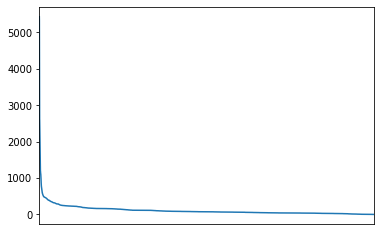

https://www.emmenmaakhetmee.nl/                      5432
https://www.instagram.com/gemeentevlissingen/        5345
https://www.wageningendoet.nu/                       4253
https://www.instagram.com/gemeenteshertogenbosch/    3099
https://www.instagram.com/gemeente_enschede/         2989
Name: top_level_url, dtype: int64

In [12]:
plot = javascript_analysis_set.copy()['top_level_url'].value_counts().plot.line()
plot.axes.get_xaxis().set_visible(False)
plt.show()

javascript_analysis_set['top_level_url'].value_counts().head(5)